#LAB EXERCISE 3

#KOMMANA SRIRAM
#23BAI1156

In [8]:
# What this cell does:
# Imports all required libraries for the experiment including PyTorch,
# TorchVision, NumPy, Matplotlib, and evaluation metrics. Also sets
# random seeds for reproducibility.
#
# Output (op) of this cell:
# No visible output. Libraries are imported and seeds are fixed.
# ------------------------------------------------------------

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

torch.manual_seed(42)
np.random.seed(42)

In [9]:
# What this cell does:
# Defines hyperparameters such as number of epochs, batch size,
# and subset size used for training.
#
# Output (op) of this cell:
# Hyperparameter values are stored in variables.
# ------------------------------------------------------------

EPOCHS = 2
BATCH_SIZE = 256
SUBSET_SIZE = 10000

In [12]:
# What this cell does:
# Defines data transformations and loads the Fashion-MNIST
# training and testing datasets.
#
# Output (op) of this cell:
# Fashion-MNIST datasets are downloaded and loaded into memory.
# ------------------------------------------------------------

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=False, transform=transform, download=True
)

In [11]:
# What this cell does:
# Creates a subset of the training data and initializes
# DataLoaders for batch-wise training and testing.
#
# Output (op) of this cell:
# train_loader and test_loader objects are created.
# ------------------------------------------------------------

from torch.utils.data import Subset

train_subset = Subset(train_dataset, range(SUBSET_SIZE))

train_loader = torch.utils.data.DataLoader(
    train_subset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

In [13]:
# What this cell does:
# Defines a fully connected neural network with three layers
# for Fashion-MNIST classification and optional regularization.
#
# Output (op) of this cell:
# BaseNet model class is defined.
# ------------------------------------------------------------

class BaseNet(nn.Module):
    def __init__(self, regularizer=None):
        super(BaseNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.regularizer = regularizer

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

###WEIGHT-BASED REGULARIZATION

In [25]:
# What this cell does:
# Defines the training loop including optional L1, L2,
# elastic net regularization, and gradient clipping.
#
# Output (op) of this cell:
# Model parameters are updated through training epochs.
# ------------------------------------------------------------

def train_model(model, optimizer, criterion, epochs=EPOCHS, l1_lambda=0.0, max_norm=None):
    model.train()

    for _ in range(epochs):
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            # L1 Regularization
            if l1_lambda > 0:
                loss += l1_lambda * sum(p.abs().sum() for p in model.parameters())

            # Elastic Net (safe check)
            if hasattr(model, "regularizer") and model.regularizer == 'elastic':
                l1 = sum(p.abs().sum() for p in model.parameters())
                l2 = sum((p**2).sum() for p in model.parameters())
                loss += 0.0005 * l1 + 0.0005 * l2

            loss.backward()
            optimizer.step()

            # Max-Norm Constraint
            if max_norm:
                with torch.no_grad():
                    for p in model.parameters():
                        norm = p.norm(2)
                        if norm > max_norm:
                            p.mul_(max_norm / norm)


In [26]:
# What this cell does:
# Evaluates a trained model on test data and computes
# accuracy, precision, recall, and F1-score.
#
# Output (op) of this cell:
# Returns a dictionary of evaluation metrics.
# ------------------------------------------------------------

def evaluate_model(model):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            y_true.extend(labels.numpy())
            y_pred.extend(preds.numpy())

    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average='macro'),
        "Recall": recall_score(y_true, y_pred, average='macro'),
        "F1-score": f1_score(y_true, y_pred, average='macro')
    }

# Training ALL Weight-Based Regularization Models

In [27]:
# What this cell does:
# Trains multiple models using different regularization techniques
# including no regularization, L1, and L2 regularization.
#
# Output (op) of this cell:
# Trained models are stored in a dictionary.
# ------------------------------------------------------------

models = {}

# No Regularization
models['No Reg'] = BaseNet()
opt = optim.Adam(models['No Reg'].parameters(), lr=0.001)
train_model(models['No Reg'], opt, nn.CrossEntropyLoss())

# L1 Regularization
models['L1'] = BaseNet()
opt = optim.Adam(models['L1'].parameters(), lr=0.001)
train_model(models['L1'], opt, nn.CrossEntropyLoss(), l1_lambda=0.001)

# L2 Regularization
models['L2'] = BaseNet()
opt = optim.Adam(models['L2'].parameters(), lr=0.001, weight_decay=0.001)
train_model(models['L2'], opt, nn.CrossEntropyLoss())

# Elastic Net
models['Elastic Net'] = BaseNet(regularizer='elastic')
opt = optim.Adam(models['Elastic Net'].parameters(), lr=0.001)
train_model(models['Elastic Net'], opt, nn.CrossEntropyLoss())

# Max-Norm
models['Max Norm'] = BaseNet()
opt = optim.Adam(models['Max Norm'].parameters(), lr=0.001)
train_model(models['Max Norm'], opt, nn.CrossEntropyLoss(), max_norm=3)

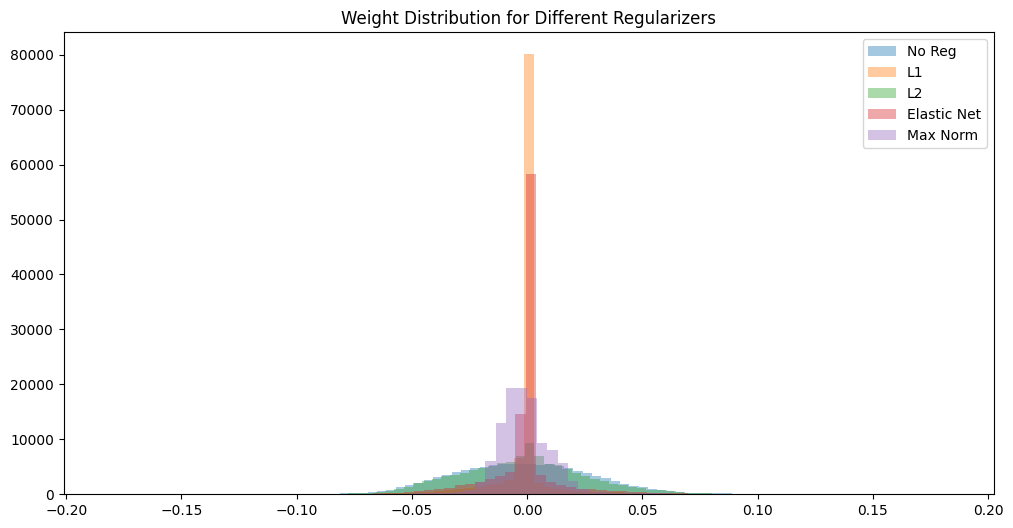

In [28]:
# What this cell does:
# Plots a combined histogram showing weight distributions
# for models trained with different regularizers.
#
# Output (op) of this cell:
# Histogram plot comparing weight distributions.
# ------------------------------------------------------------

plt.figure(figsize=(12,6))

for name, model in models.items():
    weights = torch.cat([p.view(-1) for p in model.parameters()])
    plt.hist(weights.detach().numpy(), bins=80, alpha=0.4, label=name)

plt.legend()
plt.title("Weight Distribution for Different Regularizers")
plt.show()

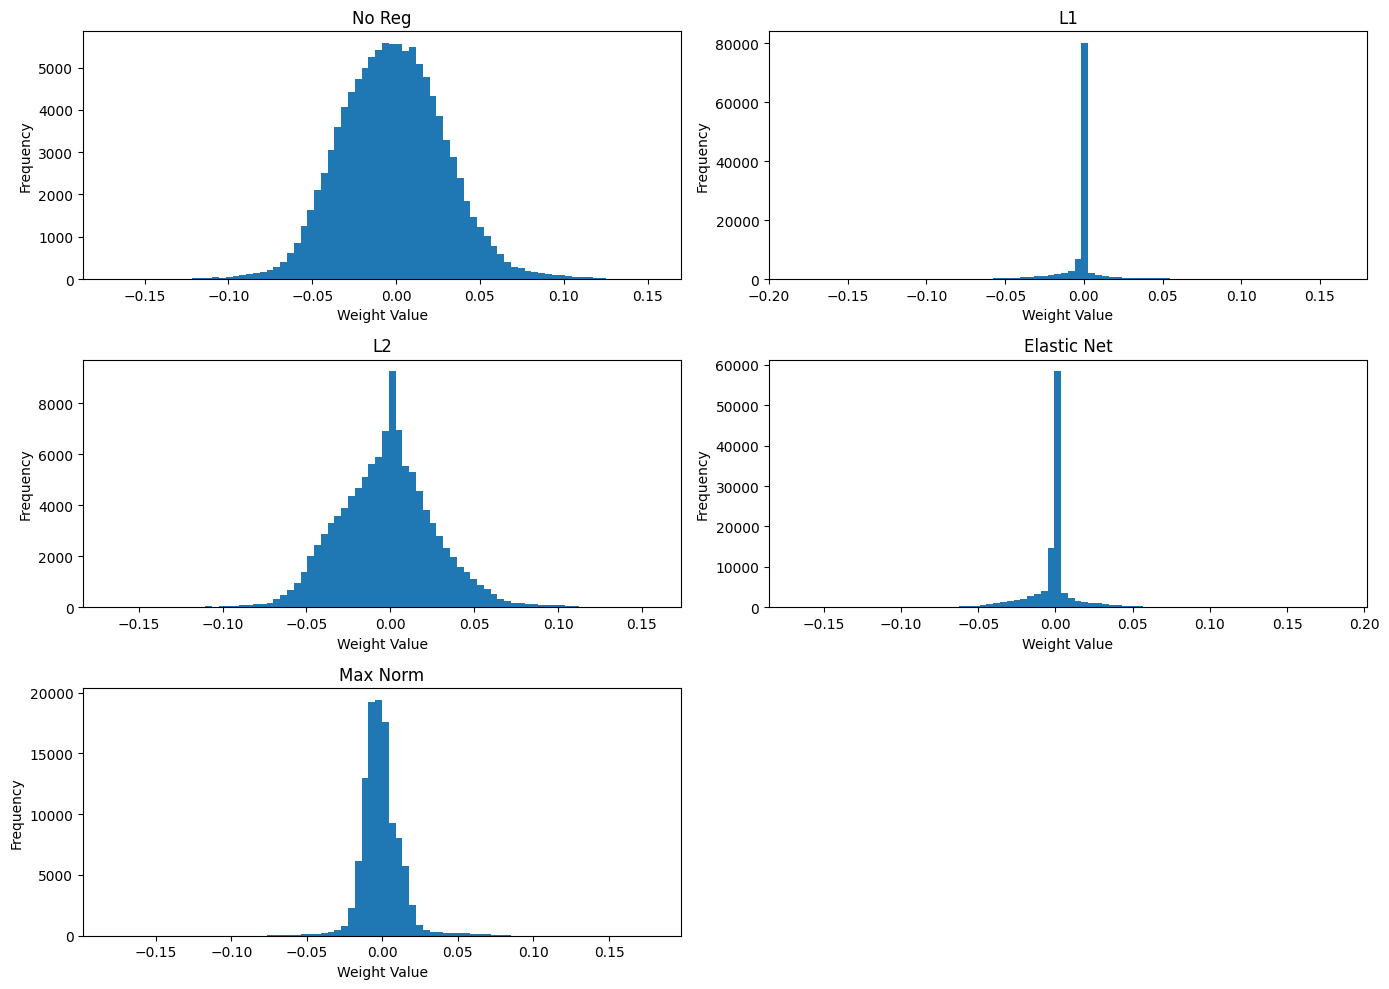

In [29]:
# What this cell does:
# Plots individual histograms of weights for each model
# to visualize sparsity and spread.
#
# Output (op) of this cell:
# Separate weight distribution plots for each model.
# ------------------------------------------------------------

plt.figure(figsize=(14,10))

for i, (name, model) in enumerate(models.items()):
    plt.subplot(3, 2, i+1)
    weights = torch.cat([p.view(-1) for p in model.parameters()])
    plt.hist(weights.detach().numpy(), bins=80)
    plt.title(name)
    plt.xlabel("Weight Value")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [30]:
# What this cell does:
# Computes sparsity ratio by counting near-zero weights
# for each trained model.
#
# Output (op) of this cell:
# Printed sparsity ratios for each model.
# ------------------------------------------------------------

threshold = 1e-3

for name, model in models.items():
    weights = torch.cat([p.view(-1) for p in model.parameters()])
    near_zero = (weights.abs() < threshold).sum().item()
    total = weights.numel()
    print(f"{name}: Sparsity Ratio = {near_zero / total:.4f}")

No Reg: Sparsity Ratio = 0.0258
L1: Sparsity Ratio = 0.6550
L2: Sparsity Ratio = 0.0481
Elastic Net: Sparsity Ratio = 0.5000
Max Norm: Sparsity Ratio = 0.1033


In [31]:
# What this cell does:
# Evaluates each trained model and prints performance metrics.
#
# Output (op) of this cell:
# Accuracy, precision, recall, and F1-score for each model.
# ------------------------------------------------------------

for name, model in models.items():
    metrics = evaluate_model(model)
    print(name, metrics)

No Reg {'Accuracy': 0.7833, 'Precision': 0.79927685783347, 'Recall': 0.7833, 'F1-score': 0.7861839406204616}
L1 {'Accuracy': 0.7435, 'Precision': 0.7553959294391124, 'Recall': 0.7434999999999999, 'F1-score': 0.7456426947747566}
L2 {'Accuracy': 0.7859, 'Precision': 0.7858814507749722, 'Recall': 0.7859, 'F1-score': 0.7833922919210504}
Elastic Net {'Accuracy': 0.7719, 'Precision': 0.7772944095189841, 'Recall': 0.7718999999999999, 'F1-score': 0.7730337881306703}
Max Norm {'Accuracy': 0.7422, 'Precision': 0.7518612255124854, 'Recall': 0.7422, 'F1-score': 0.737560871139322}


#Dropout & BatchNorm Model

In [32]:
# What this cell does:
# Defines a neural network with optional Dropout and
# Batch Normalization layers for comparison.
#
# Output (op) of this cell:
# DropoutNet model class is defined.
# ------------------------------------------------------------

class DropoutNet(nn.Module):
    def __init__(self, use_dropout=False, use_bn=False):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.5)
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(64)
        self.use_dropout = use_dropout
        self.use_bn = use_bn
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        if self.use_bn: x = self.bn1(x)
        x = self.relu(x)
        if self.use_dropout: x = self.dropout(x)

        x = self.fc2(x)
        if self.use_bn: x = self.bn2(x)
        x = self.relu(x)

        return self.fc3(x)

In [33]:
# What this cell does:
# Trains multiple configurations using dropout and
# batch normalization techniques.
#
# Output (op) of this cell:
# Trained models with different configurations.
# ------------------------------------------------------------

configs = {
    "M1_No_Reg": DropoutNet(),
    "M2_Dropout": DropoutNet(use_dropout=True),
    "M3_Dropout_Scaled": DropoutNet(use_dropout=True),
    "M4_BatchNorm": DropoutNet(use_bn=True)
}

for name, model in configs.items():
    opt = optim.Adam(model.parameters(), lr=0.001)
    train_model(model, opt, nn.CrossEntropyLoss())

In [34]:
# What this cell does:
# Computes and compares activation variance for
# different network configurations.
#
# Output (op) of this cell:
# Printed activation variance values.
# ------------------------------------------------------------

def activation_variance(model):
    model.eval()
    variances = []
    with torch.no_grad():
        for images, _ in train_loader:
            x = images.view(images.size(0), -1)
            a = model.fc1(x)
            variances.append(a.var().item())
    return np.mean(variances)

for name, model in configs.items():
    print(name, "Activation Variance:", activation_variance(model))

M1_No_Reg Activation Variance: 8.086600041389465
M2_Dropout Activation Variance: 5.576337575912476
M3_Dropout_Scaled Activation Variance: 6.288606059551239
M4_BatchNorm Activation Variance: 2.0105788111686707
